# Approach: Using Spectograms with 2D CNN

Using the spectrogram jpg file to feed into 2D CNN architecture with 2D convolutional layers (with ReLU activation) on the pixel values followed by maxpooling=> flattening=>and finally a few dense fully connected 1D neuron layers followed finally by a cross entropy sparse loss function which calculates the respective class probabilities

In [1]:
import os
os.environ["KMP_AFFINITY"] = "noverbose"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import glob
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import warnings

warnings.filterwarnings('ignore')

In [2]:
config = {
    'SEED' : 42,
    'DEBUG': False,
    'test_size':0.1,
    'img_size':256,
    'batch_size':16, # 16 for GPU
    'num_labels':0,
    'epochs':20, # 20 for GPU, iterations (16 gave sufficient accurqacy)
    'device':'GPU'
}


In [3]:
def set_seed(SEED):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    
set_seed(config['SEED'])

def get_device(device):
    if device == 'GPU':  #use the RTX3050 bro :3
        strategy = tf.distribute.MirroredStrategy() 
    print("Number of accelerators: ", strategy.num_replicas_in_sync)
    return strategy

strategy= get_device(config['device'])
config['batch_size'] = config['batch_size'] * strategy.num_replicas_in_sync

Number of accelerators:  1


## Data Preprocessing

In [4]:
## Reading spectograms and ignoring files not present

df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

df_train['ID'] = df_train['filename'].str.split('.').str[0]
df_test['ID'] = df_test['filename'].str.split('.').str[0]

train_files = pd.DataFrame(glob.glob('/content/spectograms/train/*.jpg'), columns=['spec_path'])
test_files = pd.DataFrame(glob.glob('/content/spectograms/test/*.jpg'), columns=['spec_path'])

train_files['ID'] = train_files['spec_path'].str.split('/').str[-1].str.split('.').str[0]
test_files['ID'] = test_files['spec_path'].str.split('/').str[-1].str.split('.').str[0]

df_train_spec = pd.merge(df_train, train_files, how='right', on='ID')
df_test_spec = pd.merge(df_test, test_files, how='right', on='ID')

### Training Distribution

In [5]:
config['num_labels'] = df_train_spec['genre_id'].nunique()
df_train_spec.genre_id.value_counts(normalize=True) * 100

1     15.545733
0     15.425185
2     12.969009
3      9.041137
4      8.825154
5      6.097745
6      5.931991
7      5.243860
8      4.746597
9      4.088603
10     3.998192
11     2.486313
12     2.049324
13     1.536993
14     0.713245
15     0.472148
16     0.472148
17     0.291326
18     0.065297
Name: genre_id, dtype: float64

### Train Valid Split

In [6]:
X_train, X_valid = train_test_split(df_train_spec, test_size = config['test_size'], random_state=config['SEED'], shuffle=True)
#test size is 0.1, so 10% of the data is used for validation

## Data loading

In [8]:
def process_data_train(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.random_brightness(img, 0.1)  
    #to improve the model's ability to generalize to different lighting conditions.
    img = tf.image.resize(img,[config['img_size'], config['img_size']])  #256x256
    return img, label

def process_data_valid(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img,[config['img_size'], config['img_size']])
    return img, label

train_ds_batch = tf.data.Dataset.from_tensor_slices((X_train.spec_path.values, X_train.genre_id.values))
valid_ds_batch = tf.data.Dataset.from_tensor_slices((X_valid.spec_path.values, X_valid.genre_id.values))

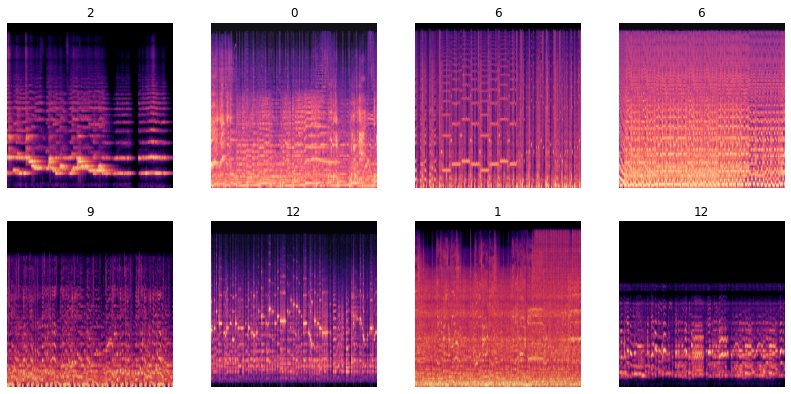

In [9]:
image_batch, label_batch = next(iter(train_ds_batch))
plt.figure(figsize=(14, 14))
for i in range(8):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i].numpy()
    plt.title(label)
    plt.axis("off")

## Modelling

In [10]:
with strategy.scope():
    ##THE NETWORK
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Rescaling(1./255, input_shape = (config['img_size'], config['img_size'], 3)),
            tf.keras.layers.Conv2D(16, kernel_size=5,  activation='relu'), #16 filters, 5x5 kernel
            tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'),
            tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, activation='relu'),
            tf.keras.layers.Conv2D(128, kernel_size=3,  activation='relu'),
            tf.keras.layers.Conv2D(256, kernel_size=3, strides= 2,  activation='relu'),
            tf.keras.layers.Conv2D(512, kernel_size=3, strides= 2, activation='relu'),
            tf.keras.layers.GlobalAveragePooling2D(), #to reduce the number of parameters
            tf.keras.layers.Flatten(), #to flatten the input into 1D array
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'), # 64 neurons connected to alla neurons in the previous layer
            tf.keras.layers.Dropout(0.2), #to prevent overfitting 20% of the neurons are dropped
            tf.keras.layers.Dense(config['num_labels'], activation='softmax')
        ]
    )

    model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer='adam',
                metrics='sparse_categorical_accuracy') #accuracy metric for multiclass classification via class probability

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 252, 252, 16)      1216      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 250, 250, 32)      4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 60, 256)       295168    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 512)       1

### Training

In [14]:
history = model.fit(train_ds_batch, epochs=config['epochs'], validation_data=valid_ds_batch)
# the training and validation metrics will be stored in hisory object

Epoch 1/20
1120/1120 [==============================] - 1091s 964ms/step - loss: 2.3927 - sparse_categorical_accuracy: 0.1940 - val_loss: 2.1789 - val_sparse_categorical_accuracy: 0.2476

Epoch 00001: val_loss improved from in to 2.17892

Epoch 00001:
Epoch 2/20
1120/1120 [==============================] - 105s 94ms/step - loss: 2.1878 - sparse_categorical_accuracy: 0.2670 - val_loss: 2.1155 - val_sparse_categorical_accuracy: 0.2717

Epoch 00002: val_loss improved from 2.17892 to 2.11552

Epoch 00002:
Epoch 3/20
1120/1120 [==============================] - 105s 94ms/step - loss: 2.1318 - sparse_categorical_accuracy: 0.2841 - val_loss: 2.1002 - val_sparse_categorical_accuracy: 0.2803

Epoch 00003: val_loss improved from 2.11552 to 2.10021, saving model to best_model.hdf5

Epoch 00003: saving model to last_model.hdf5
Epoch 4/20
1120/1120 [==============================] - 105s 94ms/step - loss: 2.0675 - sparse_categorical_accuracy: 0.3038 - val_loss: 2.0019 - val_sparse_categorical_accur

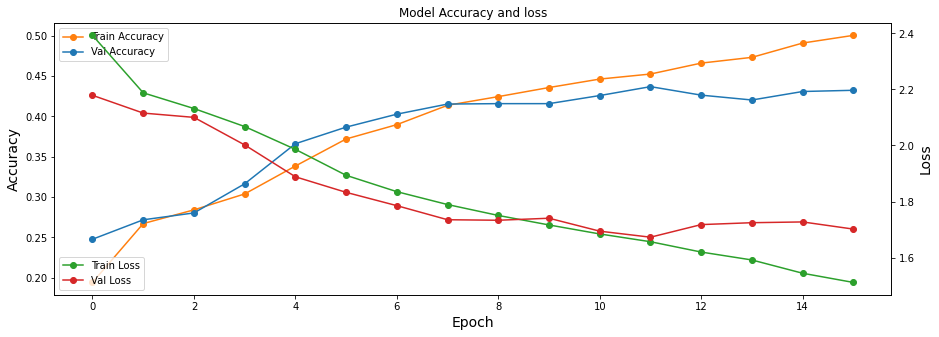

In [15]:
def plot_hist(hist):
    plt.figure(figsize=(15,5))
    local_epochs = len(hist.history["sparse_categorical_accuracy"])
    plt.plot(np.arange(local_epochs, step=1), hist.history["sparse_categorical_accuracy"], '-o', label='Train Accuracy',color='#ff7f0e')
    plt.plot(np.arange(local_epochs, step=1), hist.history["val_sparse_categorical_accuracy"], '-o',label='Val Accuracy',color='#1f77b4')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc=2)
    
    plt2.plot(np.arange(local_epochs, step=1) ,history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(np.arange(local_epochs, step=1) ,history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
    plt.legend(loc=3)
    plt.ylabel('Loss')
    plt.title("Model Accuracy and loss")
    
    plt.savefig('loss.png')
    plt.show()
    
plot_hist(history)

## Evaluation on dataset

In [16]:
pred_valid_y = model.predict(valid_ds_batch, workers=4, verbose = True)
pred_valid_y_labels = np.argmax(pred_valid_y, axis=-1)

valid_labels = np.concatenate([y.numpy() for x, y in valid_ds_batch], axis=0)
print(classification_report(valid_labels, pred_valid_y_labels ))

63/63 [==============================] - 21s 314ms/step
              precision    recall  f1-score   support

           0       0.35      0.73      0.47       299
           1       0.37      0.40      0.39       284
           2       0.40      0.48      0.51       279
           3       0.44      0.30      0.35       191
           4       0.43      0.67      0.65       171
           5       0.47      0.50      0.46       117
           6       0.52      0.36      0.43       113
           7       0.56      0.30      0.32        99
           8       0.60      0.00      0.00        86
           9       0.63      0.37      0.39        83
          10       0.67      0.02      0.04        97
          11       0.65      0.61      0.57        51
          12       0.68      0.91      0.92        43
          13       0.70      0.00      0.00        31
          14       0.67      0.00      0.00        20
          15       0.66      0.00      0.00        10
          16       0.69  